In [1]:
import pathlib
import numpy as np
import skimage
import skimage.measure
import skimage.io
import matplotlib.pyplot as plt

In [2]:
root = pathlib.Path('/media/ryan/TOSHIBA EXT/Research/datasets/uhcs-segment/images/spheroidite/')
annotations = sorted(list(root.glob('annotation*')))
micrographs = sorted(list(root.glob('micrograph*')))



In [3]:
len(annotations), len(micrographs)

(27, 27)

In [4]:
annotations[0], micrographs[0]

(PosixPath('/media/ryan/TOSHIBA EXT/Research/datasets/uhcs-segment/images/spheroidite/annotation-800C-24H-Q-1.png'),
 PosixPath('/media/ryan/TOSHIBA EXT/Research/datasets/uhcs-segment/images/spheroidite/micrograph-800C-24H-Q-1.tiff'))

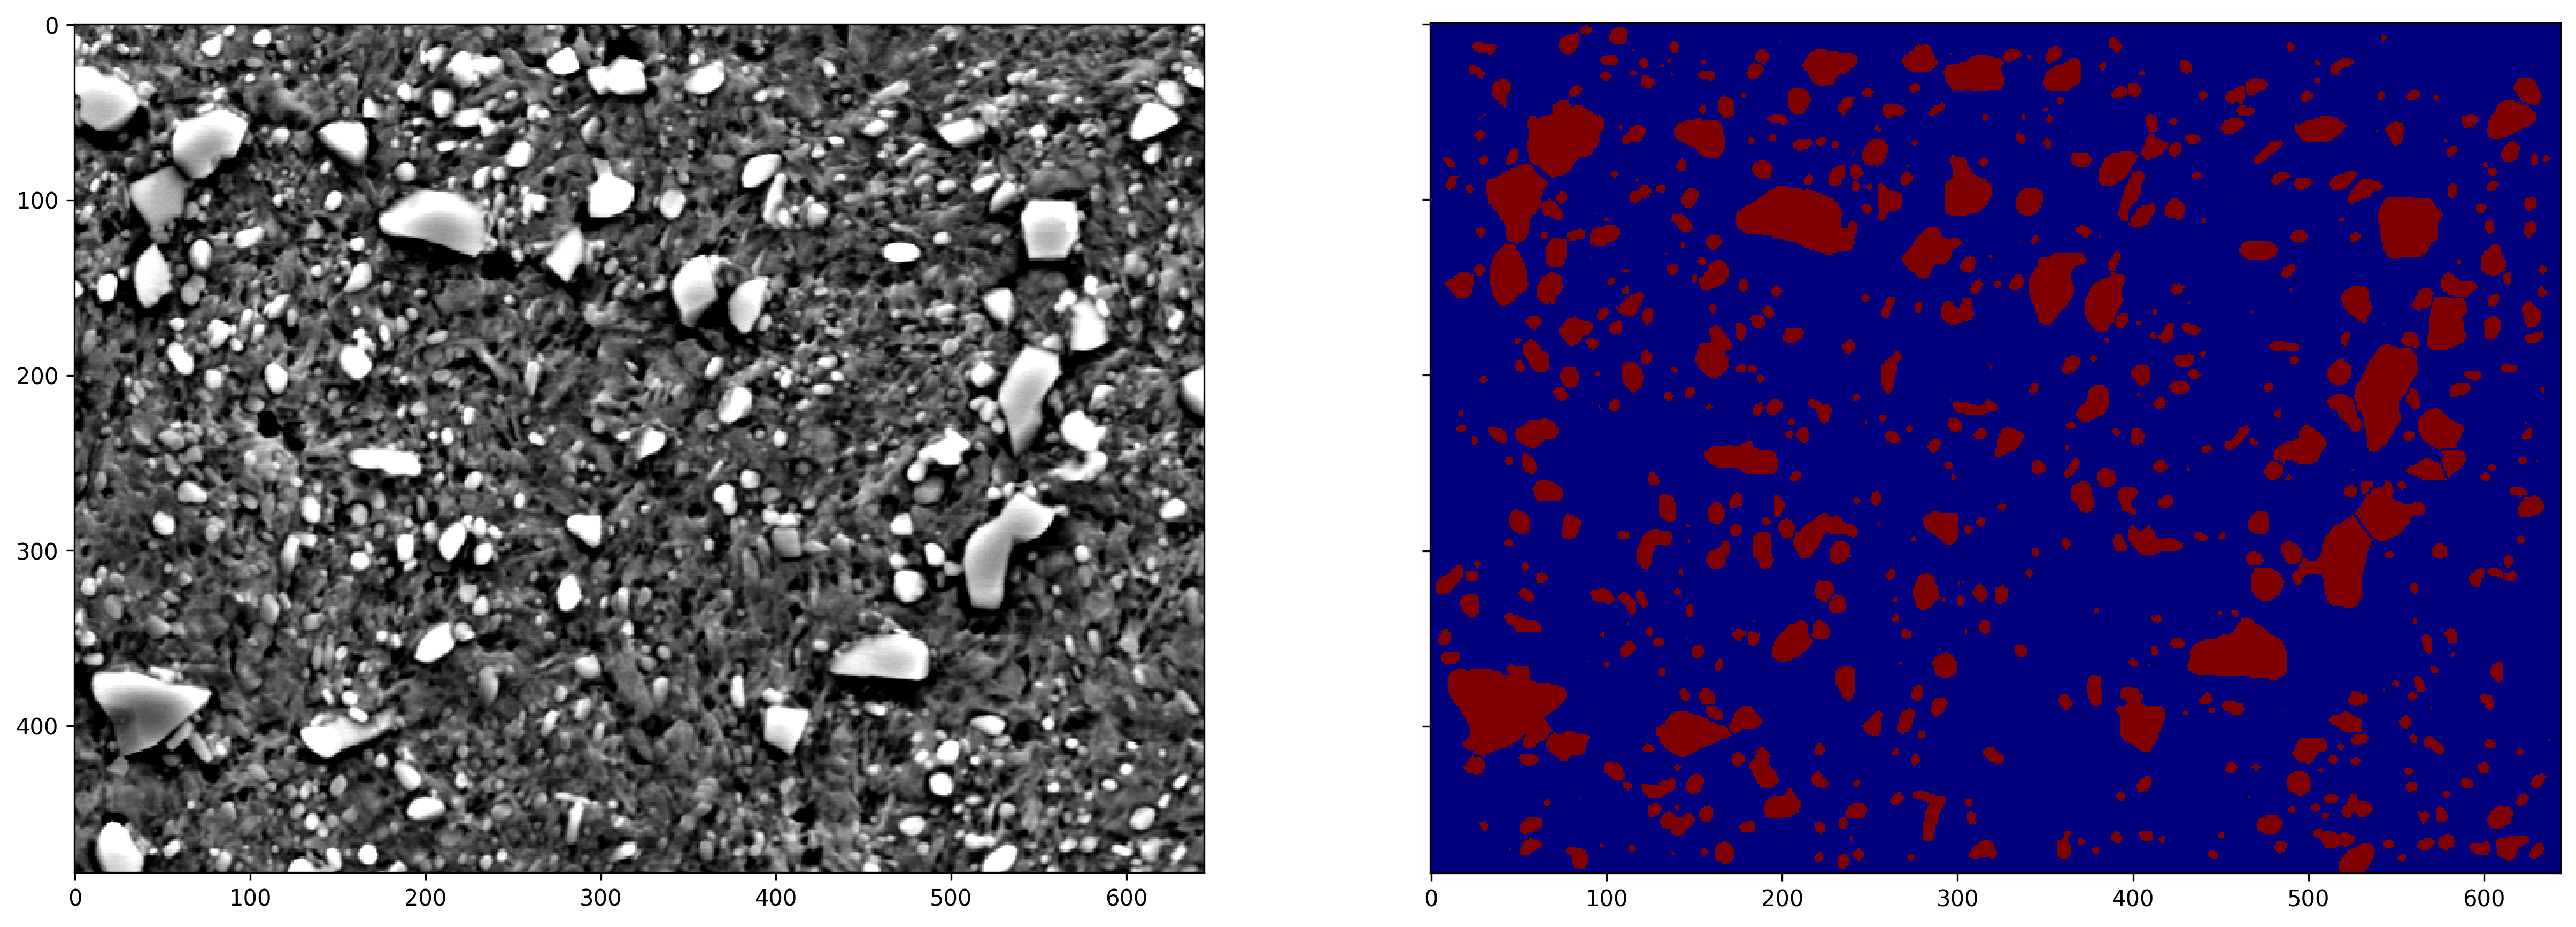

In [5]:
i = 1

a1 = skimage.io.imread(annotations[i])
i1 = skimage.io.imread(micrographs[i])

fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,10), dpi=300)
ax[0].imshow(i1, cmap='gray')
ax[1].imshow(a1, cmap='jet')

In [6]:
labels = skimage.measure.label(a1.astype(np.bool))

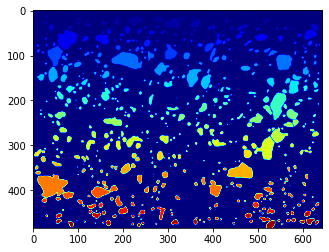

In [7]:
plt.imshow(labels, cmap='jet')

In [8]:
np.unique(labels).max()

598

In [9]:
x = np.asarray([])
x.shape

(0,)

In [ ]:
np.isemty